# CHANGES/CHECKS BEFORE THE WEBINAR:
cell 11 should be deleted and relevant code updated - this function exist in accessvis now.
Check widgets work - If they are not working, update the last cell to remove references to widget

# Historical Sea Ice
Welcome to the **Historical Sea Ice** notebook! In this notebook, we will provide a more complex example of how to use accessvis. 

In this notebook we will plot the historical sea ice cover.
* Specify northern or southern hemisphere.
* Use custom shaders to display sea ice
* Animate the sea ice every day for one year.

The data used is available in project xp65 on gadi or it will automatically be downloaded.

Since we are using local shaders, you may wish to update your current working directory.

In [1]:
import datetime
import glob
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pytz
import scipy
from tqdm.notebook import tqdm
import xarray as xr

import accessvis

# os.chdir('/path/to/dir/containing/shaders')

In [2]:
hemisphere = 'south'
# hemisphere = 'north'

this_year = 2024 # If you are NOT using gadi, change to the current year.
# The NOAA data we download is only kept for the current and previous year. Gadi has earlier data cached.

accessvis.resolution_selection(default=3)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', index=2, options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('…

## Download Data
On gadi, this data is available on xp65.
If you are not using gadi, please change base_dir below and it will download the relevant files.

NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4
* https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf
* https://nsidc.org/data/g02202/versions/4
* https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/2023/
* https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/ ??

#### Historical Data

In [3]:
base_dir = '/g/data/xp65/public/apps/access-vis-data/'

#https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/2023/
H = hemisphere[0].lower() + 'h'

#All years data
fn = f'seaice_conc_daily_{H}_*.nc'
# Cached data location
datadir = f'{base_dir}noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/'
print(datadir)

#download files if not existing
cmd = f"wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/"
p = subprocess.Popen(cmd.split(), cwd=base_dir)
p.wait()

/g/data/xp65/public/apps/access-vis-data/noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/


File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/index.html’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1978_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1979_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1980_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1981_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1982_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1983_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1984_v04r00.nc’ already there; no

0

#### Near Real Time Data
Note that on Gadi, you may not have write permissions and will not be able to update.

In [4]:
#https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/

#Get/update all daily NRT data for current year
subdir = f'noaadata.apps.nsidc.org/NOAA/G10016_V2/{hemisphere}/daily/'

# To get the latest data, you will need to delete index.html first, and then re-run.
ifn = os.path.join(base_dir, subdir, str(this_year), 'index.html')
if os.path.exists(ifn):
    try:
        os.remove(ifn)
    except PermissionError:
        print('No permission to change these files')

cmd = f"wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G10016_V2/{hemisphere}/daily/{this_year}/"
print(cmd)
p = subprocess.Popen(cmd.split(), cwd=base_dir)
p.wait()

wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/


--2025-03-14 15:27:05--  https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/
Resolving noaadata.apps.nsidc.org (noaadata.apps.nsidc.org)... 128.138.135.43
connected. to noaadata.apps.nsidc.org (noaadata.apps.nsidc.org)|128.138.135.43|:443... 
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/index.html’

..... .......... ..........             114K=0.4s

2025-03-14 15:27:07 (114 KB/s) - ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/index.html’ saved [41662]

File ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/seaice_conc_daily_icdr_sh_20240401_f18_v02r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/seaice_conc_daily_icdr_sh_20240402_f18_v02r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/seaice_conc_daily_icdr_sh_20240403_f18_v02r00.nc’ already there; n

0

## Open Data:

In [5]:
ds_sea_ice = xr.open_mfdataset(datadir + fn, combine='nested', concat_dim='tdim')
ds_sea_ice

<xarray.Dataset> Size: 62GB
Dimensions:                      (tdim: 16502, y: 332, x: 316)
Coordinates:
    time                         (tdim) datetime64[ns] 132kB dask.array<chunksize=(68,), meta=np.ndarray>
    xgrid                        (x) float32 1kB dask.array<chunksize=(316,), meta=np.ndarray>
    ygrid                        (y) float32 1kB dask.array<chunksize=(332,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc              (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    projection                   (tdim) |S1 17kB b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc        (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    latitude                     (tdim, y, x) float32 7GB dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    longitude                    (tdim, y, x) float32 7GB dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T21:22:35Z
    time_coverage_start:       1978-10-25T00:00:00Z
    time_coverage_end:         1978-12-31T23:59:59Z

In [6]:
lyear = this_year - 1 #Last year

#Note: The first 6 months are in an aggregate file, the rest in daily files
aggregate = [f'{datadir}seaice_conc_daily_{H}_{lyear}_v04r00.nc']
dailyfiles_24 = sorted(glob.glob(os.path.join(base_dir, subdir, str(this_year),f'seaice_conc_daily_icdr_{H}_2024*_f18_v02r00.nc')))
files = aggregate + dailyfiles_24

ds_sea_ice_NRT = xr.open_mfdataset(files, combine='nested', concat_dim='tdim')
ds_sea_ice_NRT

<xarray.Dataset> Size: 2GB
Dimensions:                      (tdim: 543, y: 332, x: 316)
Coordinates:
    time                         (tdim) datetime64[ns] 4kB dask.array<chunksize=(181,), meta=np.ndarray>
    xgrid                        (x) float32 1kB dask.array<chunksize=(316,), meta=np.ndarray>
    ygrid                        (y) float32 1kB dask.array<chunksize=(332,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc              (tdim, y, x) float32 228MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (tdim, y, x) float32 228MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (tdim, y, x) float32 228MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    projection                   (tdim) |S1 543B b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc        (tdim, y, x) float32 228MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (tdim, y, x) float32 228MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (tdim, y, x) float32 228MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (tdim, y, x) float32 228MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    latitude                     (tdim, y, x) float32 228MB dask.array<chunksize=(181, 332, 316), meta=np.ndarray>
    longitude                    (tdim, y, x) float32 228MB dask.array<chunksize=(181, 332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-09-26T20:17:19Z
    time_coverage_start:       2023-01-01T00:00:00Z
    time_coverage_end:         2023-06-30T23:59:59Z

Data information:

In [7]:
STEPS = ds_sea_ice_NRT['cdr_seaice_conc'].shape[0]
print('Number of time stpes:', STEPS)

latitude = np.array(ds_sea_ice['latitude'].sel(tdim=0))
longitude = np.array(ds_sea_ice['longitude'].sel(tdim=0))
print('Lat/Lon Extents:')
print(latitude[0][0], longitude[0][0])
print(latitude[-1][-1], longitude[-1][-1])

dates = np.array(ds_sea_ice['time']).astype('datetime64[D]')
dates_NRT = np.array(ds_sea_ice_NRT['time']).astype('datetime64[D]')
print('Start/End Dates: ', min(dates), max(dates))
print('Start/End NRT Dates', min(dates_NRT), max(dates_NRT))

Number of time stpes: 543
Lat/Lon Extents:
-39.36487 -42.23257
-41.58345 135.0
Start/End Dates:  1978-10-25 2024-06-30
Start/End NRT Dates 2023-01-01 2024-12-31


# Helper Functions

Helper functions to get the appropriate data:

In [8]:
def get_data_at(date):
    # This function gets the raw data from the datasets 
    
    #Find timestep index and dataset for given date
    if date.year >= this_year - 1:
        if date > dates_NRT[-1]:
            return None
        #2023 (using data up to day 309 - 5/11/2023)
        #T = date.timetuple().tm_yday - 1 #Day of year [0-365]
        #ts = dates_NRT[T]
        itemindex = np.where(dates_NRT == date)
        T = itemindex[0]
        ts = dates_NRT[T]
        assert(ts == date)
        dat = ds_sea_ice_NRT.sel(tdim=T)
    else:
        itemindex = np.where(dates == date)
        T = itemindex[0]
        ts = dates[T] #.item() #.astype(datetime.datetime)
        assert(ts == date)
        dat = ds_sea_ice.sel(tdim=T)
    return dat

def get_ice_data_at(date):
    dat = get_data_at(date)
    if dat is None:
        return dat
    dat = dat['cdr_seaice_conc']
    dat = dat.where(dat>0)
    data = np.array(dat)[0]


    if hemisphere == 'south':
        #Want to keep land max = 1.0 for antarctica, but clear islands
        #Clear tierra del fuego and nearby islands
        data[0:140,0:20] = 0.
    
        #Replace land with max ice
        data[data > 1.0] = 1.0
    else:
        #Replace land with max ice
        data[data > 1.0] = 0.0
    
    #Replace NaN with 0.0
    data[np.isnan(data)] = 0.0

    return data
   

## Plotting a sample of the data
Here we are plotting the sea ice cover for 1st June 1980. Note: you may want to change this value to align with winter if plotting northern hemisphere ice cover.

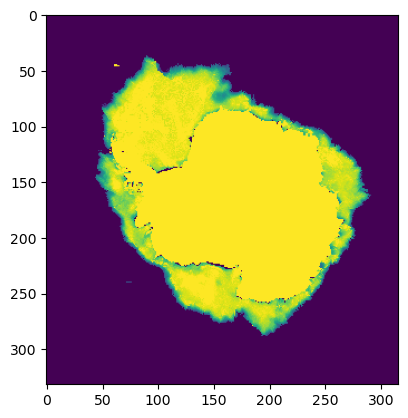

In [9]:
example_date = datetime.datetime.strptime("1980-06-01 00:00:00", "%Y-%m-%d %H:%M:%S")
example_data = get_ice_data_at(example_date.date())
plt.imshow(example_data)

## Plotting
Now we will plot the data on top of the Earth. We begin by plotting the Earth.


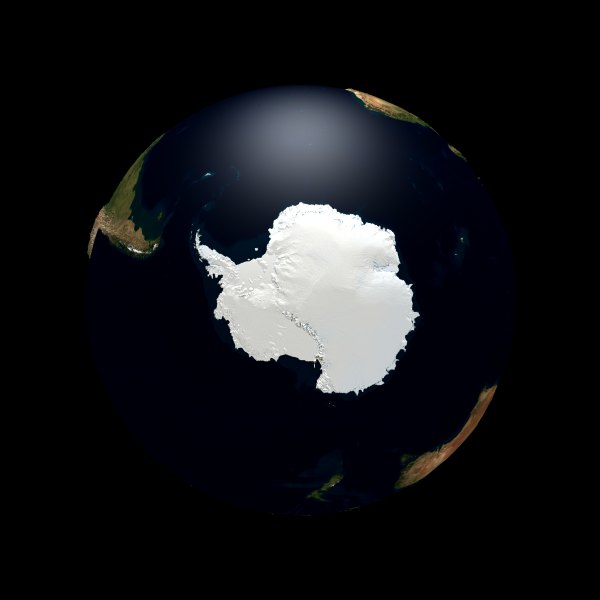

In [10]:
lv = accessvis.plot_earth(texture='bluemarble', waves=True, background='black', vertical_exaggeration=30, hemisphere=hemisphere[0].upper())
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])
lv.display(resolution=(600,600))

#### Ice rendering tweaks - sea ice render with textures
Here we are creating custom ice shaders. These are defined in local files. If this fails, be sure to check the current working directory contains the relevant files.

Lets overlay the data to see what it looks like (I'm plotting twice here as the shaders don't update immediately)

In [11]:
# NOTE: TO DELETE: This function is being added to the accessvis package

from accessvis import latlon_to_3D

def earth_patch(lv, longitudes, latitudes, altitude=0.001, name="earth_patch"):
    """
    latitudes and longitudes: ndarray
    altitude: height above sea level in km.

    patch = earth_patch(lv, latitude, longitude)
    patch.texture(data, flip=False)
    """

    altitudes = np.zeros_like(latitudes) + altitude #Raise the sea ice slightly above sea level (0.001 = 1 Metre)
    arrays = latlon_to_3D(latitudes, longitudes, altitudes)
    grid = np.dstack(arrays)


    tris0 = lv.surface(name, renderer='sortedtriangles', ambient=0.9)
    tris0.vertices(grid)

    return tris0



In [12]:
date = datetime.date(2001, 1, 1)
D = get_ice_data_at(date)

In [13]:
patch = earth_patch(lv, latitudes=latitude, longitudes=longitude)


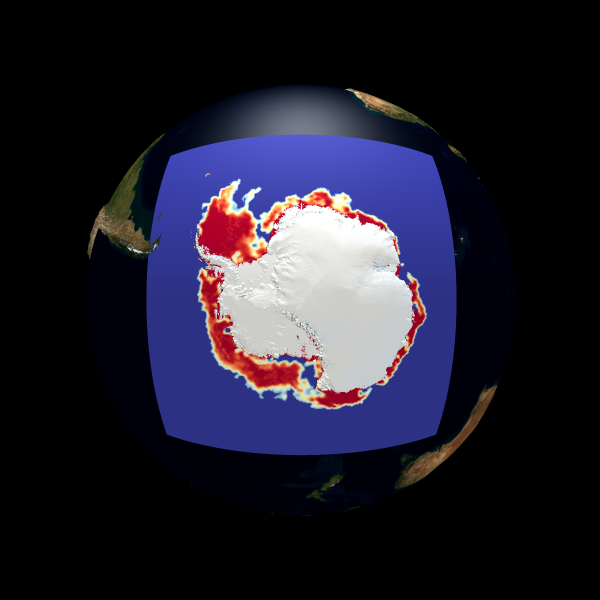

In [14]:
# patch.texture(D, flip=False) # This is OK, but makes an ugly grayscale image.
# Lets make it colourful instead.

colours = accessvis.array_to_rgba(D, colourmap='RdYlBu_r', maximum=1, minimum=0)
patch.texture(colours, flip=False)

lv.display(resolution=(600,600))

### Animation:
Below we are animating ice cover for the year 2001. Feel free to change the start date, or consider changing the code to graph the entire date range. Notice how the sun moves across a year.

We also are overlaying a season widget. We call this with `wid.update_widget()`.

We use our custom shaders by running `tris0.texture(I, flip=False)`. 


In [15]:
start = datetime.date(2001, 1, 1)
days_between_frames = 30


with lv.video(filename=f'simple_sea_ice_{hemisphere}.mp4', fps=5, resolution=(500,500)):

    for i in range(0, 365, days_between_frames):

        date = start + datetime.timedelta(days=i)
        D = get_ice_data_at(date)
        coloured = accessvis.array_to_rgba(D, colourmap='RdYlBu_r', maximum=1, minimum=0)
        patch.texture(coloured, flip=False)
        
        lv.render()


{'width': 250, 'height': 250}


<IPython.core.display.Javascript object>

In [16]:
start = datetime.date(2001, 1, 1)
days_between_frames = 30

wid = accessvis.SeasonWidget(lv=lv, scale=0.2, offset=(1,0), text_colour='white')

with lv.video(filename=f'sea_ice_{hemisphere}.mp4', fps=5, resolution=(500,500)):
    tz=pytz.timezone("Australia/Brisbane")

    for i in tqdm(range(0, 365, days_between_frames)):
        
        date = start + datetime.timedelta(days=i)
        D = get_ice_data_at(date)
        coloured = accessvis.array_to_rgba(D, colourmap='RdYlBu_r', maximum=1, minimum=0)
        patch.texture(coloured, flip=False)

        wid.update_widget(date=date)
        
        lv.rotate('z', 1)
        
        # #Update sun position
        if hemisphere == 'north':
            #Brisbane time = UTC+10, so 22:00 == UTC midday
            when = datetime.datetime(date.year, date.month, date.day, 22, 0, 0, 0, tz)
        else:
            # Brisbane tz because no daylight savings
            when = datetime.datetime(date.year, date.month, date.day, 12, 0, 0, 0, tz)
        accessvis.update_earth_datetime(lv, when=when, sunlight=True)
        
        lv.render()
wid.remove()# removing widget so we don't make loads of them if this gets run again.

  0%|          | 0/13 [00:00<?, ?it/s]

{'width': 250, 'height': 250}


<IPython.core.display.Javascript object>

## Data sources:

National Snow and Ice Data Center

- https://noaadata.apps.nsidc.org/
- https://nsidc.org/data/user-resources/help-center/how-access-and-download-noaansidc-data
- https://nsidc.org/about/data-use-and-copyright

Historical Antarctic daily satellite data
( NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4 )
Data set id: G02202
DOI: 10.7265/efmz-2t65
- https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/1978/ (-2023)
- https://nsidc.org/data/g02202/versions/4

    Meier, W. N., F. Fetterer, A. K. Windnagel, and J. S. Stewart. (2021). NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/efmz-2t65. Date Accessed 02-19-2024.

Current year Antarctic daily satellite data
( Near-Real-Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 2 )
Data set id: G10016
DOI: 10.7265/tgam-yv28
- https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/
- https://nsidc.org/data/g10016/versions/2

    Meier, W. N., F. Fetterer, A. K. Windnagel, and J. S. Stewart. (2021). Near-Real-Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 2 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/tgam-yv28. Date Accessed 02-19-2024.

#### Earth satellite imagery and ocean/water masks
- https://earthobservatory.nasa.gov/features/BlueMarble

#### Topography:
- https://visibleearth.nasa.gov/images/73934/topography
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73934/gebco_08_rev_elev_21600x10800.png

#### Bathymetry
- https://visibleearth.nasa.gov/images/73963/bathymetry
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73963/gebco_08_rev_bath_21600x10800.png

#### Textures and misc resources
https://www.manytextures.com/texture/23/sea-water/ Sea water by ManyTextures.com is licensed under a Creative Commons Attribution 4.0 International License. https://creativecommons.org/licenses/by/4.0/